In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import starbars as sb

In [2]:
dir = "./batch_results/batch_run_20250809_135041/" #batch_run_20250809_135041

In [3]:
batch_csv = dir + "summary/batch_results.csv"
batch_df = pd.read_csv(batch_csv)
batch_df.head(5)

,run_id,trained_win_rate,trained_avg_reward,basic_win_rate,basic_avg_reward,duration,timestamp
0,1,0.3970,-0.1305,0.3918,-0.1435,982.874926,2025-08-09T14:07:04.070538
1,2,0.3935,-0.1336,0.3783,-0.1738,942.398824,2025-08-09T14:22:46.994384
2,3,0.4015,-0.1231,0.3946,-0.1363,883.653824,2025-08-09T14:37:31.155354
3,4,0.3939,-0.1342,0.3912,-0.1477,856.311793,2025-08-09T14:51:48.139157
4,5,0.3966,-0.1329,0.3822,-0.1642,929.008033,2025-08-09T15:07:17.622512


### Shapiro-Wilk Normality Test
Monte Carlo simulation is a stochastic process. This means that the distributions of `trained_win_rate`, `trained_avg_reward`, `basic_win_rate`, and `basic_avg_reward` should be normal.

In [4]:
p_trained_win_rate = stats.shapiro(batch_df["trained_win_rate"]).pvalue
p_basic_win_rate = stats.shapiro(batch_df["basic_win_rate"]).pvalue
p_trained_avg_reward = stats.shapiro(batch_df["trained_avg_reward"]).pvalue
p_basic_avg_reward = stats.shapiro(batch_df["basic_avg_reward"]).pvalue

print(f"trained_win_rate is {'normal' if p_trained_win_rate > 0.05 else 'not normal'} (p={p_trained_win_rate:.4f})")
print(f"basic_win_rate is {'normal' if p_basic_win_rate > 0.05 else 'not normal'} (p={p_basic_win_rate:.4f})")
print(f"trained_avg_reward is {'normal' if p_trained_avg_reward > 0.05 else 'not normal'} (p={p_trained_avg_reward:.4f})")
print(f"basic_avg_reward is {'normal' if p_basic_avg_reward > 0.05 else 'not normal'} (p={p_basic_avg_reward:.4f})")

trained_win_rate is normal (p=0.1474)
basic_win_rate is normal (p=0.5945)
trained_avg_reward is normal (p=0.3102)
basic_avg_reward is normal (p=0.7444)


### Paired t-Test
Because we have validated that the random variables are normally distributed, we will compare the win rates and average rewards between the trained model and basic strategy using the paired t-test. Otherwise, we would use a non-parametric test like the Wilcoxon signed-rank test.

In [5]:
p_wr = stats.ttest_rel(batch_df["trained_win_rate"], batch_df["basic_win_rate"]).pvalue
p_ar = stats.ttest_rel(batch_df["trained_avg_reward"], batch_df["basic_avg_reward"]).pvalue

print(f"The difference in win rates is {'significant' if p_wr < 0.05 else 'not significant'} (p={p_wr:.5f})")
print(f"The difference in average rewards is {'significant' if p_ar < 0.05 else 'not significant'} (p={p_ar:.5f})")

The difference in win rates is significant (p=0.00008)
The difference in average rewards is significant (p=0.00000)


### Box-and-Whiskers Plot
Now we visualize how their distributions compare to each other.

2.0 0.03
2.0 0.03


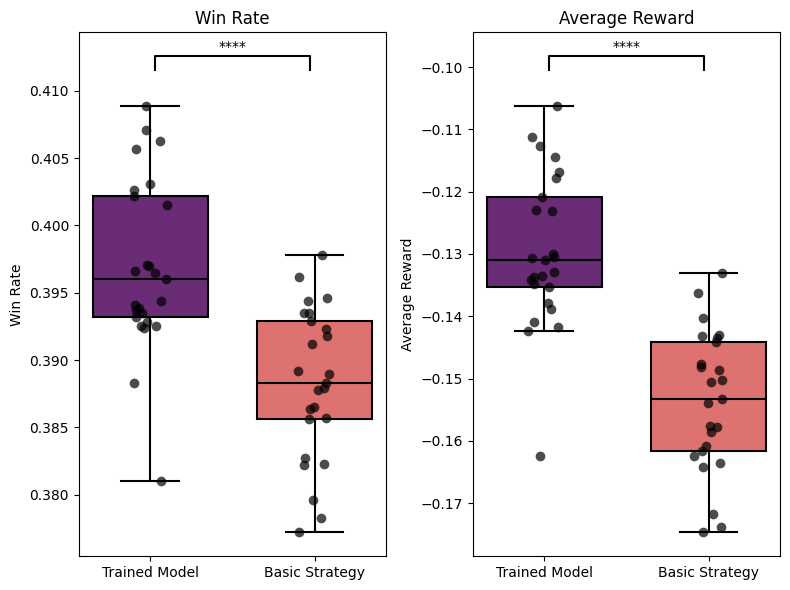

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=False)

# --- Win Rate plot ---
data_wr = batch_df.rename(
    columns={"trained_win_rate": "Trained Model", "basic_win_rate": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Win Rate"
)

sns.boxplot(
    x="Model", y="Win Rate", data=data_wr,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[0]
)
sns.stripplot(
    x="Model", y="Win Rate", data=data_wr,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[0]
)
axes[0].set_xlabel("")
axes[0].set_title("Win Rate")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_wr)], ax=axes[0])

# --- Average Reward plot ---
data_ar = batch_df.rename(
    columns={"trained_avg_reward": "Trained Model", "basic_avg_reward": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Average Reward"
)

sns.boxplot(
    x="Model", y="Average Reward", data=data_ar,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[1],
)
sns.stripplot(
    x="Model", y="Average Reward", data=data_ar,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[1]
)
axes[1].set_xlabel("")
axes[1].set_title("Average Reward")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_ar)], ax=axes[1])

plt.tight_layout()
plt.show()


It seems that the basic strategy is mathematically more optimized to maximize the player's chances of winning each hand. In other words, this strategy leads to a higher frequency of wins compared to our model. On the other hand, the fact that the average reward (expected value per hand per unit bet) is comparable between the two models offer an interesting suggestion: our model compensates losing more often by either winning larger payouts or losing less money on losing hands.

### Finding Optimal Actions for Each Combinations (Trained Model)
We're going to dive into the individual tabular datasets produced in each of the 25 runs to understand the optimal actions the trained model takes at every possible combination.

In [7]:
states_df = pd.read_csv("./csv/blackjack_states.csv")
trained_merged_df = states_df.copy()
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double
0,2,2,True,True,True
1,2,3,True,True,True
2,2,4,True,True,True
3,2,5,True,True,True
4,2,6,True,True,True


In [8]:
for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_trained_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    trained_merged_df = pd.merge(
        trained_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

In [9]:
trained_merged_df["run_nan_count"] = trained_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,2,2,False,False,False,Hit,-0.3124,Stand,-2.0160,Hit,...,-0.6633,Hit,-0.2756,Stand,-1.3333,Stand,-0.2667,Hit,-0.2300,0
1,2,2,False,False,True,Stand,-0.0741,NaN,NaN,Stand,...,-2.0000,NaN,NaN,Hit,0.0000,NaN,NaN,Hit,0.0000,8
2,2,2,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
3,2,3,False,False,False,Stand,-0.1997,Hit,-0.5033,Hit,...,-0.3444,Stand,-1.0000,Hit,-0.2134,Hit,-0.8909,Hit,-0.1714,0
4,2,3,False,False,True,Hit,-1.9800,Stand,0.0000,Stand,...,0.5000,Hit,-2.0000,Hit,-0.3425,NaN,NaN,Stand,-0.4314,2


In [10]:
# Check for row duplicates
if trained_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
trained_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
run_nan_count,25,15,14,13,12,11,10,8,7,6,5,4,3,2,1,0
count,140,1,4,1,2,6,5,6,4,3,1,6,6,6,4,625


In [11]:
print(f"Unique player_sum values: {trained_merged_df[trained_merged_df['run_nan_count'] == 25]['player_sum'].unique()}")
print(f"Unique dealer_visible values: {trained_merged_df[trained_merged_df['run_nan_count'] == 25]['dealer_visible'].unique()}")
print(f"Unique usable_ace values: {trained_merged_df[trained_merged_df['run_nan_count'] == 25]['usable_ace'].unique()}")
print(f"Unique can_split values: {trained_merged_df[trained_merged_df['run_nan_count'] == 25]['can_split'].unique()}")
print(f"Unique can_double values: {trained_merged_df[trained_merged_df['run_nan_count'] == 25]['can_double'].unique()}")

Unique player_sum values: [ 2  3  4  5  6  7  8  9 10]
Unique dealer_visible values: [ 2  3  4  5  6  7  8  9 10 11]
Unique usable_ace values: [ True]
Unique can_split values: [ True False]
Unique can_double values: [ True False]


In [12]:
trained_best_action_cols = [col for col in trained_merged_df.columns if col.startswith("best_action_")]
trained_ev_cols = [col for col in trained_merged_df.columns if col.startswith("ev_")]

trained_best_action_cols.sort()
trained_ev_cols.sort()

def get_best_action_and_ev(row, ba_cols, ev_cols, track_source=False):
    actions = ["Hit", "Stand", "Split", "Double"]
    action_mean_evs = {}
    action_sources = {}

    for action in actions:
        evs_for_action = []
        sources_for_action = []

        for ba_col, ev_col in zip(ba_cols, ev_cols):
            if row[ba_col] == action and pd.notna(row[ev_col]):
                evs_for_action.append(row[ev_col])
                sources_for_action.append(ba_col.replace("best_action_", ""))

        if evs_for_action:
            action_mean_evs[action] = np.mean(evs_for_action)
            action_sources[action] = sources_for_action

    if not action_mean_evs:
        return (np.nan, np.nan, np.nan) if track_source else (np.nan, np.nan)

    best_action = max(action_mean_evs, key=action_mean_evs.get)
    best_ev = action_mean_evs[best_action]

    if track_source:
        best_sources = ", ".join(action_sources[best_action])
        return best_action, best_ev, best_sources
    else:
        return best_action, best_ev

In [13]:
trained_merged_df[["best_action", "ev"]] = trained_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, trained_best_action_cols, trained_ev_cols)), axis=1
)

trained_merged_df = trained_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,2,2,False,False,False,Hit,-0.523118
1,2,2,False,False,True,Hit,0.021600
2,2,2,True,True,True,NaN,NaN
3,2,3,False,False,False,Hit,-0.544416
4,2,3,False,False,True,Stand,-0.116783


### Finding Optimal Actions for Each Combinations (Basic Strategy Model)
We'll now do the same for the basic strategy model.

In [14]:
bs_merged_df = states_df.copy()

for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_basic_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    bs_merged_df = pd.merge(
        bs_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

bs_merged_df["run_nan_count"] = bs_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,2,2,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
1,2,3,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
2,2,4,False,False,False,Hit,-0.1960,Hit,-0.1678,Hit,...,-0.1697,Hit,0.1451,Hit,-0.0454,Hit,-0.1556,Hit,-0.0282,0
3,2,4,False,False,True,Hit,-0.4997,Hit,-0.3193,Hit,...,-0.0865,Hit,0.1396,Hit,-0.0980,Hit,-0.3334,Hit,-0.3293,0
4,2,4,True,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25


In [15]:
# Check for row duplicates
if bs_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
bs_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3
run_nan_count,25,24,21,0
count,174,1,1,618


In [16]:
bs_best_action_cols = [col for col in bs_merged_df.columns if col.startswith("best_action_")]
bs_ev_cols = [col for col in bs_merged_df.columns if col.startswith("ev_")]

bs_best_action_cols.sort()
bs_ev_cols.sort()

bs_merged_df[["best_action", "ev"]] = bs_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, bs_best_action_cols, bs_ev_cols)), axis=1
)

bs_merged_df = bs_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,2,2,True,True,True,NaN,NaN
1,2,3,True,True,True,NaN,NaN
2,2,4,False,False,False,Hit,-0.071024
3,2,4,False,False,True,Hit,-0.253556
4,2,4,True,True,True,NaN,NaN


### Merge Results from Both Models

In [17]:
merged_df = pd.merge(
    trained_merged_df,
    bs_merged_df,
    on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
    how='outer',
    suffixes=('_trained', '_basic')
)

merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_trained,ev_trained,best_action_basic,ev_basic
0,2,2,False,False,False,Hit,-0.523118,NaN,NaN
1,2,2,False,False,True,Hit,0.021600,NaN,NaN
2,2,2,True,True,True,NaN,NaN,NaN,NaN
3,2,3,False,False,False,Hit,-0.544416,NaN,NaN
4,2,3,False,False,True,Stand,-0.116783,NaN,NaN


In [18]:
# Check for row duplicates
if merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
merged_df["run_nan_count"] = merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2
run_nan_count,2,1,0
count,140,60,620


In [19]:
best_action_cols = [col for col in merged_df.columns if col.startswith("best_action_")]
ev_cols = [col for col in merged_df.columns if col.startswith("ev_")]

best_action_cols.sort()
ev_cols.sort()

merged_df[["best_action", "ev", "source"]] = merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, best_action_cols, ev_cols, track_source=True)), axis=1
)

merged_df = merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev","source"]]
merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev,source
0,2,2,False,False,False,Hit,-0.523118,trained
1,2,2,False,False,True,Hit,0.021600,trained
2,2,2,True,True,True,NaN,NaN,NaN
3,2,3,False,False,False,Hit,-0.544416,trained
4,2,3,False,False,True,Stand,-0.116783,trained


In [20]:
print(f"There are {merged_df.isna().any(axis=1).sum()} rows with missing action data before dropping.")

merged_cleaned_df = merged_df.dropna()

print(f"There are {merged_cleaned_df.isna().any(axis=1).sum()} rows with missing action data after dropping.")

There are 140 rows with missing action data before dropping.
There are 0 rows with missing action data after dropping.


In [21]:
uniq_source_counts = merged_cleaned_df["source"].value_counts()

print(f"Among all finalized expected values, {uniq_source_counts.iloc[0]} are sourced from basic strategy\
 results and {uniq_source_counts.iloc[1]} from trained model results.")

Among all finalized expected values, 369 are sourced from basic strategy results and 259 from trained model results.


### Final Combined Model Application

In [22]:
from typing import List

def state_representation(df: pd.DataFrame, player_values: List[int], dealer_visible: int, have_split: bool):
    player_sum = np.sum(player_values)
    usable_ace = False
    can_double = False
    can_split = False

    if 1 in player_values:
        usable_ace = True
    if len(player_values) == 2:
        can_double = True
        if not have_split and player_values[0] == player_values[1]:
            can_split = True

    matched_row = df[
        (df["player_sum"] == player_sum) &
        (df["dealer_visible"] == dealer_visible) &
        (df["usable_ace"] == usable_ace) &
        (df["can_split"] == can_split) &
        (df["can_double"] == can_double)
    ]
    print(matched_row)

    if not matched_row.empty:
        return matched_row[["best_action", "ev", "source"]].values[0]  # Return action and EV as array
    else:
        return ("NO_DATA", "-999", "NO_DATA")

In [23]:
action, ev, source = state_representation(merged_cleaned_df, [1, 4, 4, 4], 10, False)
print(f"Best Action: {action}, EV: {ev}, Source: {source}")

     player_sum  dealer_visible  usable_ace  can_split  can_double  \
494          13              10        True      False       False   

    best_action     ev   source  
494      Double  0.612  trained  
Best Action: Double, EV: 0.612, Source: trained


In [24]:
merged_cleaned_df.to_csv("merged_results.csv", index=False)